

## Author: Hank Hoang
**Date created: ** March 28th 2023<br>
**Last modified: ** April 2nd 2023<br>

## Importing the necessary libraries and loading data

In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [6]:
#Reading the data
df = pd.read_csv('data_0.csv')

In [7]:
#Looking at data
df.head()


,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


* Some observations showed that the reported date was later than the incident occurred to date. Therefore, I just selected the occurred incident date for model's prediction later.
* The Date Occ column has repeated 12:00:00 AM text, it's invaluable information, so I deleted it and combined it with the time column next to it for further time series model.

In [8]:
df['DATE OCC'] = df['DATE OCC'].str.replace('12:00:00 AM', '')

In [9]:
df['TIME OCC'] = df['TIME OCC'].apply(lambda x: '{0:0>4}'.format(x))
df['TIME OCC'] = pd.to_datetime(df['TIME OCC'], format='%H%M').dt.strftime('%H:%M')

In [ ]:
df.shape

(5000, 28)

In [10]:
# Combine date and time into a single datetime column
df['datetime'] = pd.to_datetime(df['DATE OCC'] + ' ' + df['TIME OCC'])


* Refine the dataset by removing unnecessary columns ( DR_NO, Crm Cd 3, Crm Cd 4, Location and Cross Street) 
* Crm Cd 2, Crm Cd 3, Crm Cd 4,Cross Street contains blank cells
* Location attribute has a lot of incomplete information due to privacy reasons.

In [11]:
# Refine the dataset by removing unnecessary columns ( DR_NO,Crm Cd 2, Crm Cd 3, Crm Cd 4)
df = df.drop(columns=['DR_NO','Crm Cd 1','Crm Cd 2','Crm Cd 3','Crm Cd 4','Date Rptd','Cross Street','LOCATION'])

In [ ]:
df.describe()

,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,LAT,LON
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,1627.000000,5000.000000,5000.000000,5000.000000
mean,1350.911400,4.073000,455.251200,1.384000,501.036200,30.770600,287.606800,373.540258,500.750200,33.998340,-118.190827
std,647.974031,3.796282,378.819536,0.486407,206.651939,21.512706,223.954334,116.441831,206.442457,0.967106,3.345331
min,1.000000,1.000000,101.000000,1.000000,110.000000,-1.000000,101.000000,101.000000,110.000000,0.000000,-118.650300
25%,925.000000,2.000000,212.000000,1.000000,331.000000,19.000000,101.000000,400.000000,331.000000,34.022000,-118.305825
50%,1430.000000,3.000000,361.000000,1.000000,442.000000,31.000000,122.000000,400.000000,442.000000,34.045900,-118.274350
75%,1900.000000,5.000000,509.000000,2.000000,626.000000,46.000000,501.000000,400.000000,626.000000,34.062400,-118.247400
max,2359.000000,21.000000,2189.000000,2.000000,956.000000,99.000000,968.000000,515.000000,956.000000,34.320800,0.000000


In [ ]:
df.corr()

,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,LAT,LON
AREA,1.000000,0.997536,-0.049200,-0.088031,0.047660,-0.013425,-0.031132,0.004149,-0.003985
Rpt Dist No,0.997536,1.000000,-0.049703,-0.089606,0.049294,-0.015304,-0.030515,0.002408,-0.002469
Part 1-2,-0.049200,-0.049703,1.000000,0.772139,0.153901,0.236385,0.388567,-0.008624,0.007242
Crm Cd,-0.088031,-0.089606,0.772139,1.000000,-0.030879,0.158251,0.315192,-0.024282,0.020784
Vict Age,0.047660,0.049294,0.153901,-0.030879,1.000000,0.094391,0.067697,0.017668,-0.014454
Premis Cd,-0.013425,-0.015304,0.236385,0.158251,0.094391,1.000000,0.205529,0.010638,-0.010882
Weapon Used Cd,-0.031132,-0.030515,0.388567,0.315192,0.067697,0.205529,1.000000,0.056080,0.015447
LAT,0.004149,0.002408,-0.008624,-0.024282,0.017668,0.010638,0.056080,1.000000,-0.994993
LON,-0.003985,-0.002469,0.007242,0.020784,-0.014454,-0.010882,0.015447,-0.994993,1.000000


## Exploratory data analysis

In [14]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

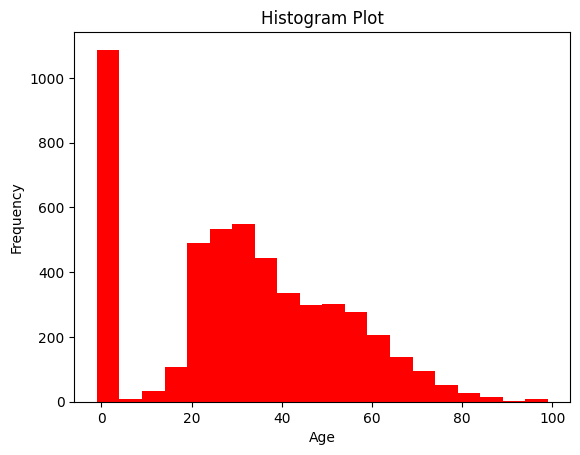

In [ ]:
# create a histogram plot with 20 bins
plt.hist(df['Vict Age'], bins=20, color= 'red')

# add title and labels
plt.title('Histogram Plot')
plt.xlabel('Age')
plt.ylabel('Frequency')

# show the plot
plt.show()

## What time of day do criminal activities happen the most? 

In [22]:
time=df['TIME OCC'].value_counts().nlargest(10)
time

12:00    164
20:00    159
19:00    148
18:00    132
17:00    124
15:00    123
22:00    123
21:00    108
16:00    107
13:00    100
Name: TIME OCC, dtype: int64

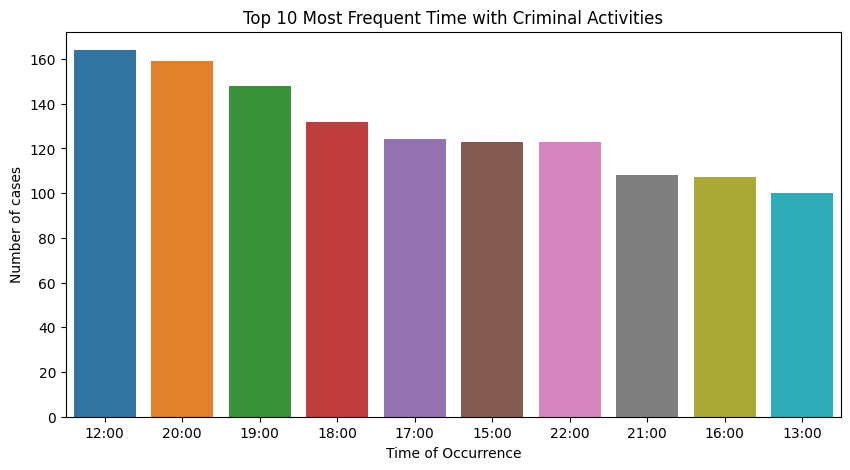

In [48]:
plt.figure(figsize=(10,5))
sns.barplot(x=time.index, y=time.values)
plt.title('Top 10 Most Frequent Time with Criminal Activities')
plt.xlabel('Time of Occurrence')
plt.ylabel('Number of cases')
plt.show()

*Surprisingly, most criminal activities happened at noon.*

**What type of crime happened at that time?**

In [38]:
subset_df = df.loc[df['TIME OCC'] == "12:00", :]
type_crim=subset_df['Crm Cd Desc'].value_counts().nlargest(3)

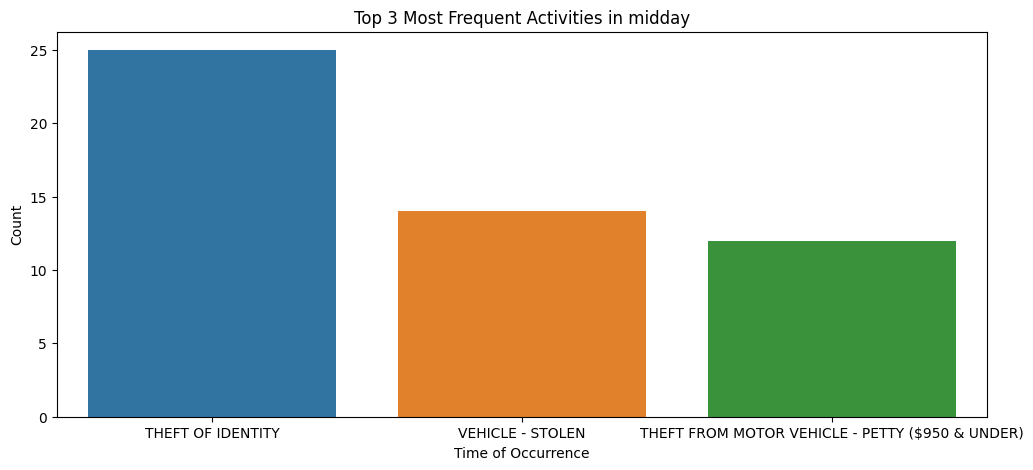

In [41]:
plt.figure(figsize=(12,5))
sns.barplot(x=type_crim.index, y=type_crim.values)
plt.title('Top 3 Most Frequent Activities in midday')
plt.xlabel('Time of Occurrence')
plt.ylabel('Count')
plt.show()

Most of incidents in the midday were related to theft.

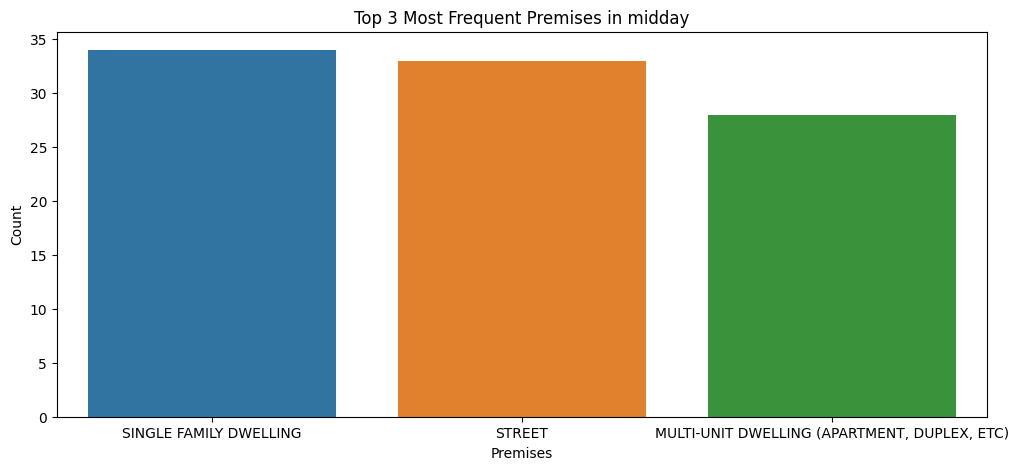

In [46]:
premises = subset_df['Premis Desc'].value_counts().nlargest(3)
plt.figure(figsize=(12,5))
sns.barplot(x=type_crim.index, y=type_crim.values)
plt.title('Top 3 Most Frequent Premises in midday')
plt.xlabel('Premises')
plt.ylabel('Count')
plt.show()

Houses and streets are the most common places where incidents happened in the midday.

**Hypothesis:** midday is when people and police have less caution about criminals, and criminals tend to choose places where there's no sign of police.  

## Victim Descent

In [ ]:
mapping = {'A': 'Asian', 'B': 'Black', 'C': 'Chinese','F':'Filipino','H':'Hispanic/Latin/Mexican','I':'Indian', 'K':'Korean', 'O':'Others', 'V':'Vietnamese','W':'White','X':'Unknowns'}
df['Vict Descent'].map(mapping).value_counts()

Hispanic/Latin/Mexican    1693
White                      933
Black                      780
Unknowns                   525
Others                     300
Asian                      155
Chinese                     15
Filipino                    14
Korean                      14
Indian                      10
Vietnamese                   4
Name: Vict Descent, dtype: int64

* Because the number of Chinese, Filipino, Korean, Indian and Vietnamese are not significant and can group them into Asian group.


* Others and Unknowns cases can group together into one group.

In [ ]:
# Count the values
df1 = df['Vict Descent'].map(mapping).value_counts().reset_index()

# Rename the columns
df1.columns = ['Vict Descent', 'count']

In [ ]:
df1.loc[3, 'Vict Descent'] = 'Others'
df1.loc[6, 'Vict Descent'] = 'Asian'
df1.loc[7, 'Vict Descent'] = 'Asian'
df1.loc[8, 'Vict Descent'] = 'Asian'
df1.loc[9, 'Vict Descent'] = 'Asian'
df1.loc[10, 'Vict Descent'] = 'Asian'

In [ ]:
grouped=df1.groupby('Vict Descent').sum()

In [ ]:
grouped

,count
Vict Descent,
Asian,212
Black,780
Hispanic/Latin/Mexican,1693
Others,825
White,933


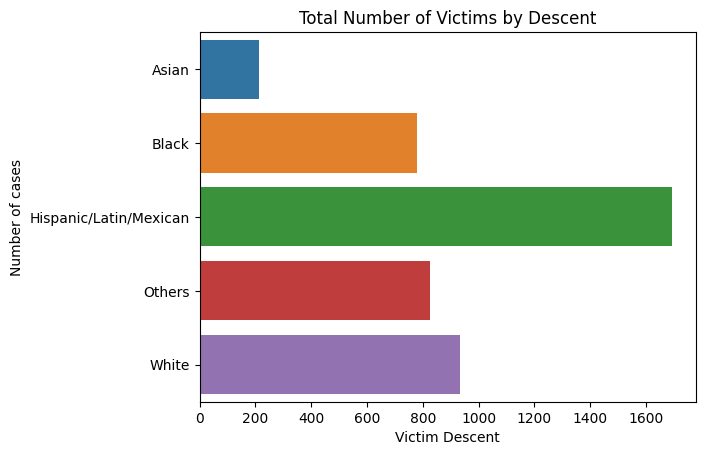

In [ ]:
grouped = df1.groupby('Vict Descent').sum().reset_index()

# Create barplot using Seaborn
sns.barplot(x='count', y='Vict Descent', data=grouped, orient='h')

# Add labels and title
plt.xlabel('Victim Descent')
plt.ylabel('Number of cases')
plt.title('Total Number of Victims by Descent')

# Show plot
plt.show()

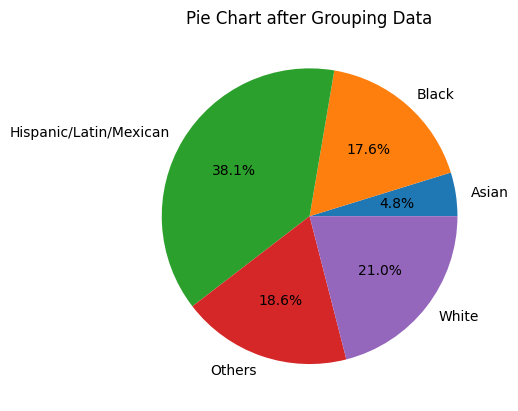

In [ ]:
# Create pie chart using Matplotlib
plt.pie(grouped['count'], labels=grouped['Vict Descent'], autopct='%1.1f%%')

# Add title
plt.title('Proportion of Victims Descent')
# Show plot
plt.show()

## Sex of the victims

<Axes: xlabel='Vict Sex', ylabel='count'>

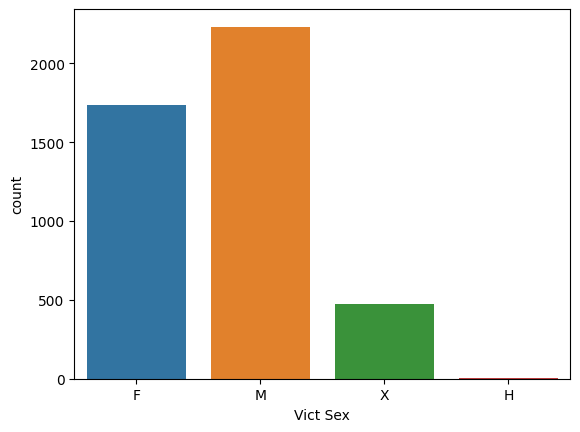

In [51]:
sns.countplot(x='Vict Sex', data=df)


Male victims are more than female victims.

## Common types of crime

In [53]:
df['Crm Cd Desc'].value_counts().nlargest(10)

VEHICLE - STOLEN                                           442
BATTERY - SIMPLE ASSAULT                                   439
BURGLARY FROM VEHICLE                                      396
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)        332
THEFT PLAIN - PETTY ($950 & UNDER)                         328
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    294
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            244
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             231
BURGLARY                                                   222
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                   198
Name: Crm Cd Desc, dtype: int64

In [54]:
df['Weapon Desc'].value_counts()

STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    909
UNKNOWN WEAPON/OTHER WEAPON                       193
VERBAL THREAT                                     120
HAND GUN                                           74
OTHER KNIFE                                        38
KNIFE WITH BLADE 6INCHES OR LESS                   29
UNKNOWN FIREARM                                    23
SEMI-AUTOMATIC PISTOL                              21
MACE/PEPPER SPRAY                                  19
BOTTLE                                             16
STICK                                              15
PIPE/METAL PIPE                                    13
ROCK/THROWN OBJECT                                 12
BLUNT INSTRUMENT                                   11
KNIFE WITH BLADE OVER 6 INCHES IN LENGTH           10
REVOLVER                                            9
AIR PISTOL/REVOLVER/RIFLE/BB GUN                    9
KITCHEN KNIFE                                       9
SIMULATED GUN               

In [ ]:
sns.barplot(x='Crime', y=top_crimes.values, hue='Weapon Type', data=df, palette=color_palette)
